In [1]:
using Plots; gr()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
using JLD2
data_home = "../MountainCar"

"../MountainCar"

In [2]:
pwd()

"/home/matthewmcleod/Documents/Masters/curiosity/plotting"

# Plotting

In [97]:
ic = ItemCollection(joinpath(data_home, "data"));

In [98]:
swept_params = diff(ic)

Dict{String,Array} with 5 entries:
  "demon_learner"       => ["TB", "TBAuto"]
  "behaviour_alpha"     => [0.03125, 0.0625]
  "runs"                => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  21, 22, 23, 24, 2…
  "demon_alpha"         => [0.0078125, 0.015625, 0.03125, 0.0625, 0.125]
  "use_external_reward" => Bool[0, 1]

In [110]:
function load_results(ic, logger_key)
    num_results = length(ic)
    results = []
    for itm in ic.items
        data = FileIO.load(joinpath(itm.folder_str, "results.jld2"))["results"]
        println(data[logger_key])
        push!(results,data[logger_key])
    end
    
    return cat(results..., dims = 3)
end

load_results (generic function with 1 method)

In [100]:
# After implementing, I think I saw there is a Iterators.product that does this?
function combine(dict_arr, key, vals)
    new_dict_arr = []
    for dict in dict_arr
        for val in vals
            new_dict = deepcopy(Dict(dict))
            new_dict[key] = val
            push!(new_dict_arr, new_dict)
        end
    end
    return new_dict_arr
end

function split_algo(algo_ic, swept_params)
    println(swept_params)
    dicts = [Dict()]
    for k in swept_params
        list_of_params = diff(algo_ic)[k]
        dicts = combine(dicts, k, list_of_params)
    end
    return dicts
end

split_algo (generic function with 1 method)

In [101]:
algo_divisor_keys = ["use_external_reward","demon_learner"]
algo_divisors = split_algo(ic, algo_divisor_keys)

["use_external_reward", "demon_learner"]


4-element Array{Any,1}:
 Dict{Any,Any}("demon_learner" => "TB","use_external_reward" => false)
 Dict{Any,Any}("demon_learner" => "TBAuto","use_external_reward" => false)
 Dict{Any,Any}("demon_learner" => "TB","use_external_reward" => true)
 Dict{Any,Any}("demon_learner" => "TBAuto","use_external_reward" => true)

In [102]:
sweep_keys = ["behaviour_alpha","demon_alpha"]
sweep_divisors = split_algo(ic,sweep_keys)

["behaviour_alpha", "demon_alpha"]


10-element Array{Any,1}:
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"demon_alpha" => 0.0078125)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"demon_alpha" => 0.015625)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"demon_alpha" => 0.03125)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"demon_alpha" => 0.0625)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"demon_alpha" => 0.125)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"demon_alpha" => 0.0078125)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"demon_alpha" => 0.015625)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"demon_alpha" => 0.03125)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"demon_alpha" => 0.0625)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"demon_alpha" => 0.125)

In [103]:
function get_best(ic, sweep_params, metric)
    splits = split_algo(ic,sweep_params)
    errors = ones(length(splits)) * Inf
    for (ind, split) in enumerate(splits)
        res = load_results(search(ic, split), metric)
        error = mean(res)
        errors[ind] = error
    end
    low_err, low_err_ind = findmin(errors)
    
    return search(ic, splits[low_err_ind])
end

get_best (generic function with 1 method)

In [104]:
function get_stats(data;per_gvf=false)
    mean_per_gvf, std_per_gvf = mean(data,dims=3)[:,:,1], std(data,dims=3)[:,:,1]
    
    return a,b = if per_gvf == true
        mean_per_gvf, std_per_gvf
    else
        mean(mean_per_gvf,dims=1)[1,:], mean(std_per_gvf,dims=1)[1,:]
    end
end

get_stats (generic function with 1 method)

In [105]:
algos_ics = [search(ic,algo_divisor) for algo_divisor in algo_divisors]
sweep_params = ["behaviour_alpha","demon_alpha"]
best_per_algo_ics = [get_best(algo_ic,sweep_params, :mc_error) for algo_ic in algos_ics]

["behaviour_alpha", "demon_alpha"]
["behaviour_alpha", "demon_alpha"]
["behaviour_alpha", "demon_alpha"]
["behaviour_alpha", "demon_alpha"]


4-element Array{ItemCollection,1}:
 ItemCollection(Reproduce.Item[Reproduce.Item("../MountainCar/data/RP_0_0x10e742961f90e969", Dict{String,Any}("steps" => 50000,"demon_alpha" => 0.03125,"use_external_reward" => false,"_GIT_INFO" => "0","save_keys" => ["demon_learner", "runs", "demon_alpha", "behaviour_alpha", "use_external_reward"],"numtilings" => 8,"demon_learner" => "TB","behaviour_alpha" => 0.0625,"numtiles" => 8,"exploring_starts" => true…), ["demon_learner", "logger_keys", "behaviour_gamma", "steps", "behaviour_learner", "behaviour_alpha", "numtiles", "behaviour_trace", "save_dir", "demon_alpha", "use_external_reward", "demon_alpha_init", "exploring_starts", "lambda", "save_keys", "runs", "seed", "numtilings", "intrinsic_reward", "demon_policy_type"]), Reproduce.Item("../MountainCar/data/RP_0_0x41439bcf39ba5d1c", Dict{String,Any}("steps" => 50000,"demon_alpha" => 0.03125,"use_external_reward" => false,"_GIT_INFO" => "0","save_keys" => ["demon_learner", "runs", "demon_alpha", "beh

In [114]:
function print_params(ic, algo_params, sweep_params)
end

load_results(best_per_algo_ics[4],:episode_length)

[582, 1104, 764, 106, 307, 101, 780, 817, 519, 103, 183, 97, 104, 91, 100, 95, 83, 172, 90, 101, 262, 80, 240, 85, 101, 229, 187, 101, 87, 158, 82, 82, 85, 97, 106, 97, 91, 180, 93, 153, 89, 104, 87, 95, 97, 85, 83, 82, 97, 164, 103, 89, 163, 85, 92, 161, 95, 100, 96, 94, 185, 93, 89, 98, 94, 138, 189, 173, 89, 89, 97, 248, 95, 160, 97, 83, 160, 105, 130, 89, 86, 100, 93, 158, 89, 105, 163, 165, 254, 99, 111, 96, 90, 99, 88, 107, 97, 101, 236, 159, 190, 179, 97, 107, 94, 88, 100, 123, 106, 224, 95, 99, 97, 84, 258, 85, 98, 164, 170, 288, 180, 88, 87, 103, 131, 96, 156, 88, 101, 96, 166, 169, 85, 87, 93, 92, 101, 106, 88, 85, 88, 216, 105, 160, 113, 144, 124, 98, 193, 91, 89, 90, 113, 85, 191, 278, 107, 107, 212, 163, 354, 107, 197, 186, 246, 192, 116, 128, 89, 95, 105, 190, 93, 102, 87, 88, 93, 88, 164, 93, 90, 104, 118, 96, 95, 87, 86, 108, 94, 122, 99, 104, 147, 85, 90, 93, 92, 83, 97, 97, 92, 99, 117, 93, 88, 109, 181, 96, 101, 179, 85, 89, 92, 111, 112, 103, 98, 92, 122, 118, 88, 8

[1713, 1114, 1442, 96, 477, 174, 88, 87, 241, 282, 93, 96, 87, 84, 90, 84, 84, 89, 208, 97, 106, 91, 282, 93, 236, 93, 96, 85, 163, 87, 200, 160, 101, 86, 183, 157, 96, 149, 156, 164, 107, 93, 267, 197, 107, 82, 168, 93, 101, 193, 92, 88, 111, 88, 86, 88, 87, 93, 85, 93, 162, 98, 100, 160, 131, 89, 100, 94, 194, 211, 202, 108, 91, 168, 95, 92, 80, 94, 163, 156, 92, 99, 95, 87, 158, 105, 102, 161, 100, 84, 229, 99, 82, 92, 193, 89, 98, 88, 164, 139, 89, 103, 99, 95, 91, 94, 87, 103, 103, 88, 84, 215, 88, 87, 188, 106, 161, 89, 107, 164, 154, 83, 91, 96, 106, 105, 98, 86, 157, 102, 95, 193, 90, 98, 94, 126, 99, 105, 94, 119, 108, 89, 98, 169, 91, 96, 102, 91, 163, 104, 179, 85, 83, 84, 167, 86, 188, 91, 92, 109, 88, 95, 90, 109, 102, 91, 87, 106, 200, 100, 110, 117, 193, 82, 104, 90, 86, 164, 96, 99, 84, 108, 263, 154, 102, 213, 140, 83, 87, 95, 84, 199, 170, 128, 311, 105, 170, 109, 161, 125, 96, 182, 246, 84, 84, 133, 95, 119, 101, 90, 165, 223, 86, 84, 103, 91, 85, 88, 101, 99, 91, 85

[2105, 1605, 194, 499, 351, 125, 94, 208, 90, 85, 98, 279, 197, 89, 212, 94, 162, 169, 162, 97, 89, 170, 235, 100, 85, 85, 160, 82, 100, 186, 93, 88, 88, 163, 155, 103, 91, 159, 95, 95, 154, 155, 101, 84, 86, 84, 82, 89, 83, 101, 105, 85, 106, 82, 102, 100, 97, 82, 86, 82, 95, 82, 100, 91, 83, 95, 99, 161, 87, 151, 100, 191, 91, 225, 169, 92, 102, 180, 108, 187, 359, 94, 96, 90, 343, 103, 84, 90, 86, 89, 85, 90, 102, 97, 93, 83, 104, 90, 157, 88, 83, 203, 90, 83, 88, 161, 83, 87, 169, 90, 83, 98, 166, 88, 99, 100, 85, 102, 198, 85, 100, 187, 86, 84, 197, 88, 195, 86, 84, 92, 203, 87, 155, 101, 112, 90, 87, 92, 86, 160, 105, 211, 101, 95, 93, 93, 88, 108, 164, 102, 89, 177, 87, 83, 103, 153, 191, 85, 96, 87, 269, 91, 183, 88, 88, 165, 92, 85, 161, 106, 92, 224, 101, 100, 103, 168, 161, 92, 156, 88, 101, 191, 108, 173, 211, 102, 107, 130, 108, 153, 89, 97, 85, 101, 88, 91, 93, 128, 85, 95, 160, 87, 90, 163, 182, 89, 90, 160, 107, 105, 87, 225, 168, 97, 140, 123, 133, 153, 97, 101, 96, 88

[1504, 432, 115, 904, 752, 277, 92, 633, 90, 105, 83, 331, 90, 90, 174, 258, 91, 170, 90, 91, 89, 173, 326, 237, 93, 177, 106, 108, 93, 160, 163, 90, 93, 152, 169, 107, 210, 82, 88, 100, 88, 89, 100, 85, 82, 92, 184, 85, 185, 91, 86, 95, 113, 204, 106, 153, 86, 97, 90, 93, 96, 86, 105, 90, 86, 160, 92, 86, 226, 91, 114, 92, 182, 104, 101, 90, 95, 116, 210, 255, 90, 88, 96, 95, 97, 170, 88, 162, 100, 88, 106, 89, 154, 99, 101, 94, 163, 168, 106, 99, 107, 93, 100, 90, 98, 92, 88, 102, 267, 187, 91, 116, 224, 98, 161, 99, 85, 102, 171, 223, 107, 89, 96, 102, 94, 93, 109, 102, 196, 86, 94, 92, 88, 107, 167, 84, 91, 147, 130, 105, 96, 84, 95, 110, 85, 99, 107, 101, 92, 126, 93, 99, 85, 88, 98, 97, 88, 126, 179, 127, 104, 89, 84, 108, 98, 86, 102, 88, 89, 102, 101, 103, 83, 82, 90, 212, 84, 119, 121, 105, 105, 91, 97, 92, 94, 109, 117, 106, 85, 92, 95, 104, 156, 205, 94, 164, 100, 103, 103, 102, 125, 301, 100, 118, 277, 298, 303, 429, 102, 94, 96, 265, 164, 96, 94, 89, 94, 98, 99, 157, 100, 

LoadError: [91mDimensionMismatch("mismatch in dimension 1 (expected 379 got 378)")[39m

In [50]:


data = [smooth(get_stats(load_results(ic,:mc_error))[1],10) for ic in best_per_algo_ics]
data_std = [smooth(get_stats(load_results(ic,:mc_error))[2],10) for ic in best_per_algo_ics]
function get_label(ic, label_keys)
    label_str = ""
    for k in label_keys
        label_str = string(label_str, " ",k,":", ic.items[1].parsed_args[k])
    end
    return label_str
end
labels = [get_label(ic, algo_divisor_keys) for ic in best_per_algo_ics]

println([get_label(ic, sweep_params) for ic in best_per_algo_ics])


[" behaviour_alpha:0.0625 demon_alpha:0.03125", " behaviour_alpha:0.0625 demon_alpha:0.015625", " behaviour_alpha:0.0625 demon_alpha:0.03125", " behaviour_alpha:0.0625 demon_alpha:0.03125"]


In [93]:
function plot_mc_errors(errors,labels; step_increment = 50)
    num_samples = length(errors[1])
    xticks=collect(step_increment:step_increment:num_samples*step_increment)
    p = plot(xlabel="Steps", ylabel="MSE")
    for (ind,err) in enumerate(errors)
        plot!(p,xticks,err,label=labels[ind])
    end
    display(p)
end


plot_mc_errors (generic function with 3 methods)

In [94]:
function smooth(data, k)
    smoothed_data = zeros(size(data))
    for i = 1:size(data, 1)
        if i < k
            smoothed_data[i] = mean(data[1:i])
        else
            smoothed_data[i] = mean(data[i - k + 1:i])
        end
    end
    return smoothed_data
end

smooth (generic function with 1 method)

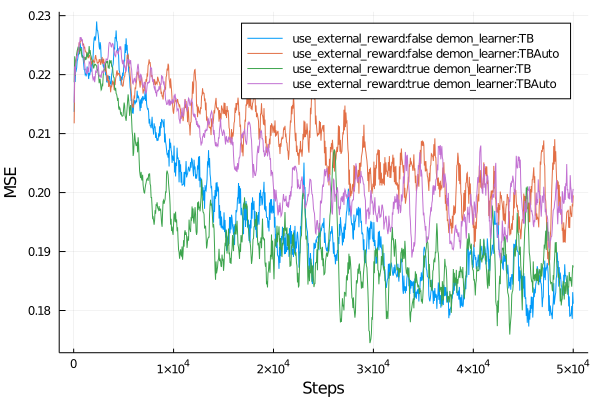

In [95]:
plot_mc_errors(data, labels,step_increment = 50)


In [96]:
savefig("./plots/MountainCar.png")

In [91]:
best_external = get_best(external_ics,"demon_alpha",:mc_error)
best_internal = get_best(intrinsic_ics,"demon_alpha",:mc_error)

println(diff(best_external))
println(diff(best_internal))

external_mean,external_std = get_stats(load_results(best_external,:mc_error))
internal_mean,internal_std = get_stats(load_results(best_internal,:mc_error))

LoadError: [91mUndefVarError: external_ics not defined[39m

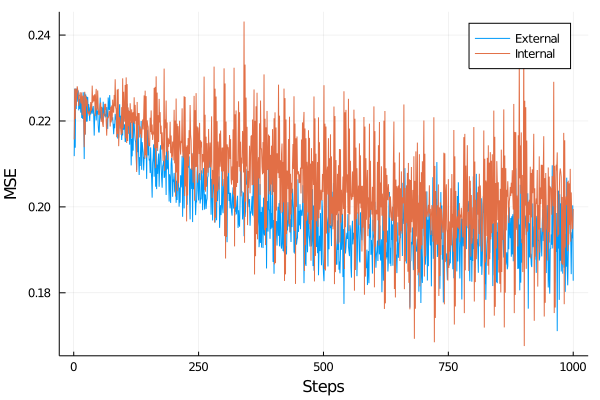

In [272]:
plot_mc_errors([external_mean, internal_mean], ["External" "Internal"])

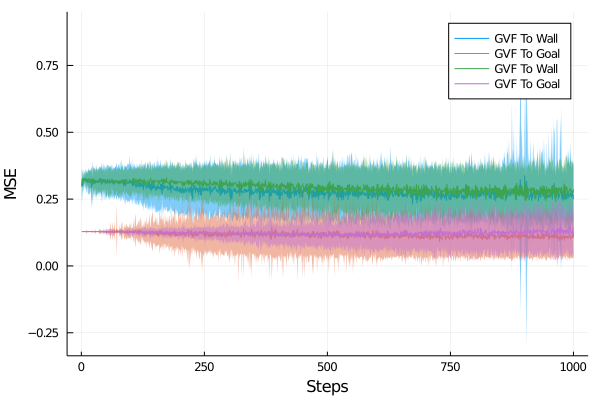

In [250]:
p = plot()
for algo_ic in best_performers
    perf = load_results(algo_ic, :mc_error)
    mean_per_gvf, std_per_gvf = get_stats(perf, per_gvf = true)
    plot!(p, mean_per_gvf', xlabel = xlabel, ylabel = ylabel, label=GVF_names, ribbon=std_per_gvf')
end
display(p)

In [165]:
TB_ic = search(ic, Dict("demon_learner" => "TB"))

ItemCollection(Reproduce.Item[Reproduce.Item("../MountainCar/data/RP_0_0x17ba4f278235ff75", Dict{String,Any}("steps" => 20000,"demon_alpha" => 0.0625,"use_external_reward" => true,"_GIT_INFO" => "0","save_keys" => ["demon_learner", "runs", "demon_alpha", "behaviour_alpha"],"numtilings" => 8,"demon_learner" => "TB","behaviour_alpha" => 0.0625,"numtiles" => 8,"exploring_starts" => true…), ["demon_learner", "logger_keys", "behaviour_gamma", "steps", "behaviour_learner", "behaviour_alpha", "numtiles", "behaviour_trace", "save_dir", "demon_alpha", "use_external_reward", "demon_alpha_init", "exploring_starts", "lambda", "save_keys", "runs", "seed", "numtilings", "intrinsic_reward", "demon_policy_type"]), Reproduce.Item("../MountainCar/data/RP_0_0x1b599b7d999d74b", Dict{String,Any}("steps" => 20000,"demon_alpha" => 0.0078125,"use_external_reward" => true,"_GIT_INFO" => "0","save_keys" => ["demon_learner", "runs", "demon_alpha", "behaviour_alpha"],"numtilings" => 8,"demon_learner" => "TB","beh

In [166]:
best = get_best(TB_ic, "demon_alpha", :mc_error)

0.20831373488016416
0.20416268346315813
0.20097784883684153
0.20515993135518623


ItemCollection(Reproduce.Item[Reproduce.Item("../MountainCar/data/RP_0_0x1bc3586e74473f63", Dict{String,Any}("steps" => 20000,"demon_alpha" => 0.03125,"use_external_reward" => true,"_GIT_INFO" => "0","save_keys" => ["demon_learner", "runs", "demon_alpha", "behaviour_alpha"],"numtilings" => 8,"demon_learner" => "TB","behaviour_alpha" => 0.0625,"numtiles" => 8,"exploring_starts" => true…), ["demon_learner", "logger_keys", "behaviour_gamma", "steps", "behaviour_learner", "behaviour_alpha", "numtiles", "behaviour_trace", "save_dir", "demon_alpha", "use_external_reward", "demon_alpha_init", "exploring_starts", "lambda", "save_keys", "runs", "seed", "numtilings", "intrinsic_reward", "demon_policy_type"]), Reproduce.Item("../MountainCar/data/RP_0_0x1fd193e9a420f885", Dict{String,Any}("steps" => 20000,"demon_alpha" => 0.03125,"use_external_reward" => true,"_GIT_INFO" => "0","save_keys" => ["demon_learner", "runs", "demon_alpha", "behaviour_alpha"],"numtilings" => 8,"demon_learner" => "TB","beh

In [167]:
TB_data = load_results(best, :mc_error)

2×400×20 Array{Float64,3}:
[:, :, 1] =
 0.326488  0.326488  0.326488  0.326488  …  0.18197   0.30314    0.184185
 0.128561  0.128561  0.128561  0.128561     0.127457  0.0653167  0.056559

[:, :, 2] =
 0.326488  0.326488  0.326488  0.326488  …  0.11199     0.119078  0.323642
 0.128561  0.128561  0.128561  0.128561     0.00528594  0.03182   0.0682576

[:, :, 3] =
 0.275014  0.326488  0.153515  0.326488  …  0.324366    0.130637   0.335853
 0.128561  0.128561  0.128561  0.128561     0.00501605  0.0209939  0.332815

...

[:, :, 18] =
 0.326488  0.326488  0.326488  0.326488  …  0.509986    0.339056  0.339348
 0.128561  0.128561  0.128561  0.128561     0.00496679  0.532633  0.0658221

[:, :, 19] =
 0.326488  0.326488  0.326488  0.326488  …  0.429844   0.326529    0.123285
 0.128561  0.128561  0.128561  0.128561     0.0791713  0.00639758  0.126664

[:, :, 20] =
 0.326488  0.326488  0.326488  0.326488  …  0.362243  0.251007  0.203202
 0.128561  0.128561  0.128561  0.128561     0.13818   0.13412

In [168]:
mean_per_gvf, std_per_gvf = mean(TB_data,dims=3), std(TB_data, dims=3)

mean_per_gvf = mean_per_gvf[:,:,1]
std_per_gvf = std_per_gvf[:,:,1]

2×400 Array{Float64,2}:
 0.0624575  0.0  0.0666678  2.73138e-15  …  0.102695  0.0816739  0.0664
 0.0        0.0  0.0        0.0             0.11406   0.129171   0.106049

In [169]:
xlabel = "Steps"
ylabel = "MSE"
GVF_names = ["GVF To Wall" "GVF To Goal"]

1×2 Array{String,2}:
 "GVF To Wall"  "GVF To Goal"

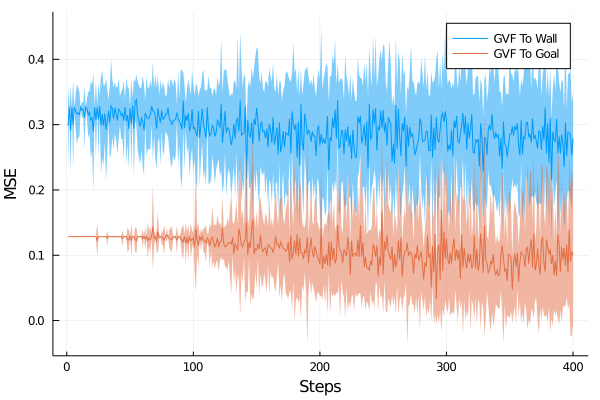

In [171]:
plot(mean_per_gvf', xlabel = xlabel, ylabel = ylabel, label=GVF_names, ribbon=std_per_gvf')
# plot(mean_per_gvf', xlabel = xlabel, ylabel = ylabel, label=GVF_names)

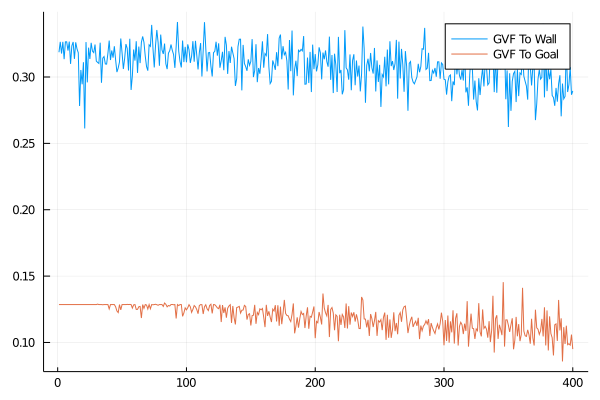

1
true


In [212]:
function plot_mc_errors(errors,labels)
    println(length(errors))
#     plot(errors[1],label = labels[1])
    p = plot()
    for (ind,err) in enumerate(errors)
#         println("ER")
#         println(err)
        println(err == errors[1])
        plot!(p, err,label=labels[ind])
    end
    display(p)
end
plot_mc_errors([mean_per_gvf'],[GVF_names])

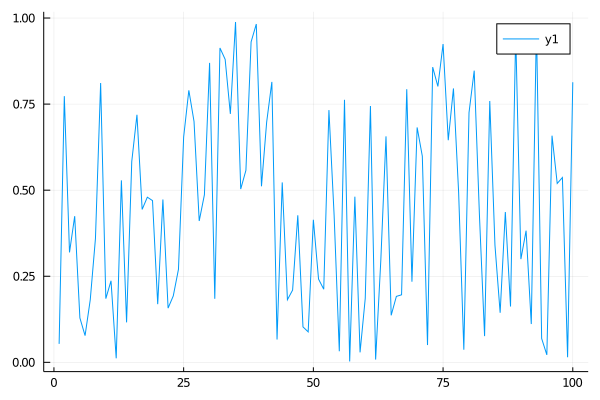

In [211]:
p = plot()
for i in 1:1
    plot!(p,rand(100))
end
display(p)

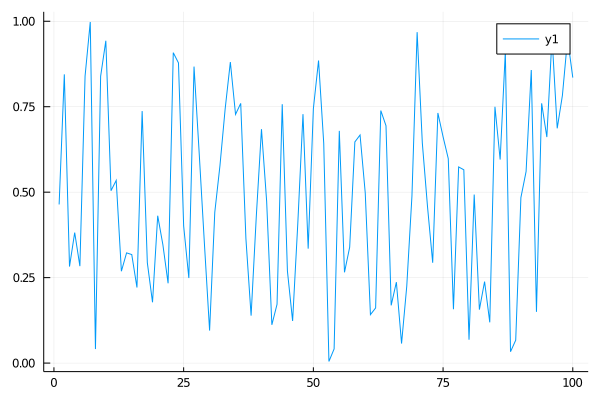

In [210]:
p = plot()
plot!(p,rand(100))


In [64]:
savefig("./plots/mc_err.png")

In [127]:
ic_gvfn_adam = ItemCollection(joinpath(data_home, "compassworld_gvfn_adam/data"));

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.22136696498900177, 0.09174684066370062, 0.13742553462376156, 0.21546018456262103, 0.24086908437829552, 0.4108762533954928][0.000685302492873593, 0.01576425200929578, 0.018016805781695205, 0.00019420066395696477, 0.0001420473634212361, 0.0003570002664489418]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.23567941136970885, 0.19919374625089953, 0.038491329433835424, 0.015456523648132558, 0.019141334483580175, 0.02967973934568604, 0.03550410232159923, 0.08277195954740921, 0.23944385566451304, 0.4111725843369968][0.00117814891387513, 0.0034762370487239225, 0.0028895776162177426, 0.0004576473655168009, 0.003377458031201559, 0.00616030123106119, 0.003894715214714131, 0.004720552997484916, 0.006759361038640632, 0.00014494982646116048]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.19594094093671838, 0.07093647096917233, 0.016445492289939755, 0.014194802789080762, 0.015144747294153053, 0.015599217449575481, 0.028396071101483712, 0.05286656708130825, 0.22808952364965132, 0.41135429581420635][0.0014826519012807505, 0.002818950898560041, 0.0005535380225010373, 0.0003672546280477116, 0.00017145362233548437, 0.00032743282546493534, 0.0013846460157234744, 0.0019984408583700202, 0.00503862991929995, 5.57064971166392e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.232346884710206, 0.21608926715023896, 0.1888170352228497, 0.018207011150888693, 0.0109954205569502, 0.006989228505163951, 0.015433552672326805, 0.09132279607259952, 0.16546207178771838, 0.4095666590257153][0.0007982379889346155, 0.0004250307048077503, 0.0012293744695988644, 0.0013145091673702578, 0.0005999366980000653, 0.0003491357728991125, 0.0010309369970688538, 0.01020179593464344, 0.0029350372378072935, 0.0017434205181799944]


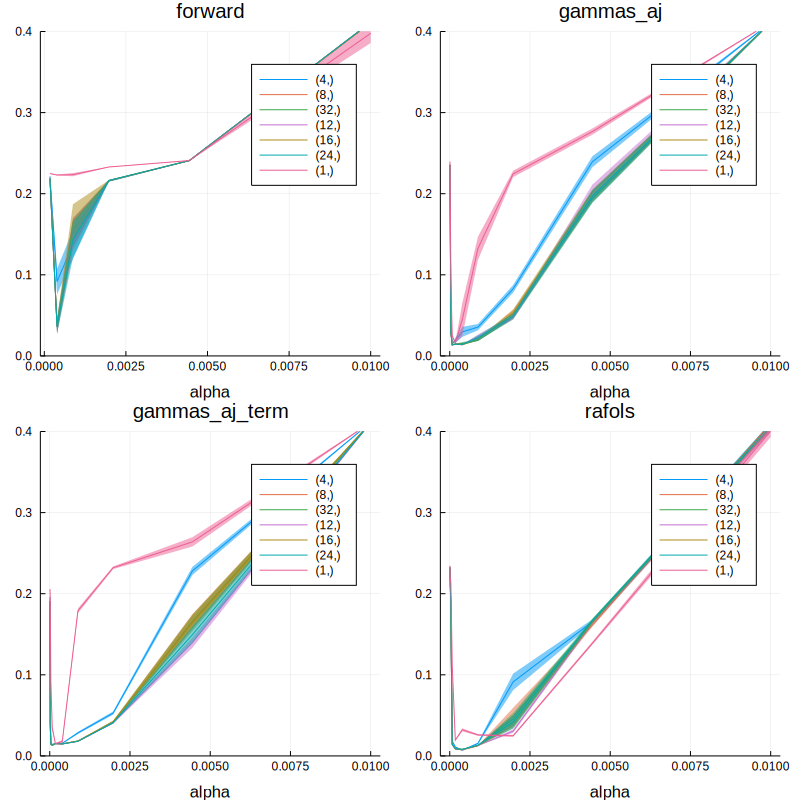

In [128]:
plot_gvfn_stepsize_sense(ic_gvfn_adam, "end", ylim=(0.0, 0.4))

In [4]:
ic_rnn = ItemCollection(joinpath(data_home, "compassworld_rnn/data"));

In [62]:
0.01*1.5.^(-18:2:1)

10-element Array{Float64,1}:
 6.766394845988643e-6  
 1.5224388403474448e-5 
 3.425487390781751e-5  
 7.707346629258939e-5  
 0.00017341529915832613
 0.0003901844231062338 
 0.0008779149519890261 
 0.0019753086419753087 
 0.0044444444444444444 
 0.01                  

In [61]:
diff(ic_rnn_adam)["alpha"]

10-element Array{Float64,1}:
 6.766394845988643e-6  
 1.5224388403474448e-5 
 3.425487390781751e-5  
 7.707346629258939e-5  
 0.00017341529915832613
 0.0003901844231062338 
 0.0008779149519890261 
 0.0019753086419753087 
 0.0044444444444444444 
 0.01                  

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.21625652451739655, 0.19349755589569273, 0.12900814212316253, 0.06938445851038558, 0.052642093881500984, 0.07233643920053531, 0.08935960642555117, 0.09644422533824104, 0.0977475399750538, 10000.0, 10000.0][0.0031286650643342195, 0.009689462721975838, 0.020539527062096892, 0.017207626055550942, 0.022132192575397246, 0.027164948755114646, 0.023348790994261917, 0.027620525732610982, 0.028466066155447774, 0.0, 0.0]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.22867534258727357, 0.22673472649699722, 0.2246023138045469, 0.22233066857361336, 0.22020074752242302, 0.21946151270081385, 0.21275686615310213, 0.19812461493369446, 0.20733346471294167, 0.18424503845736953, 0.1699187255912283][0.000400465671299861, 0.0004360397958840628, 0.0004621355337387327, 0.00047024660714263164, 0.0005019017409799473, 0.0009215552309886329, 0.0031537863449157847, 0.0056370823357530155, 0.007528095689330704, 0.009338465605092175, 0.0073170679043805305]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.22847845318396165, 0.2269845290628508, 0.22506080154389174, 0.22345522062801132, 0.22035759984968822, 0.21860764361628798, 0.21572801803887015, 0.20523924365508428, 0.20055683841956845, 0.19155712805795955, 0.18242906754946106][0.0004096864634307476, 0.0004232651034745703, 0.00048801245895629405, 0.0005306869866126442, 0.000556731252065923, 0.0009314601590301591, 0.002054685043591376, 0.0038432492692005884, 0.0062065063634117, 0.006171876365358443, 0.007103572140171154]


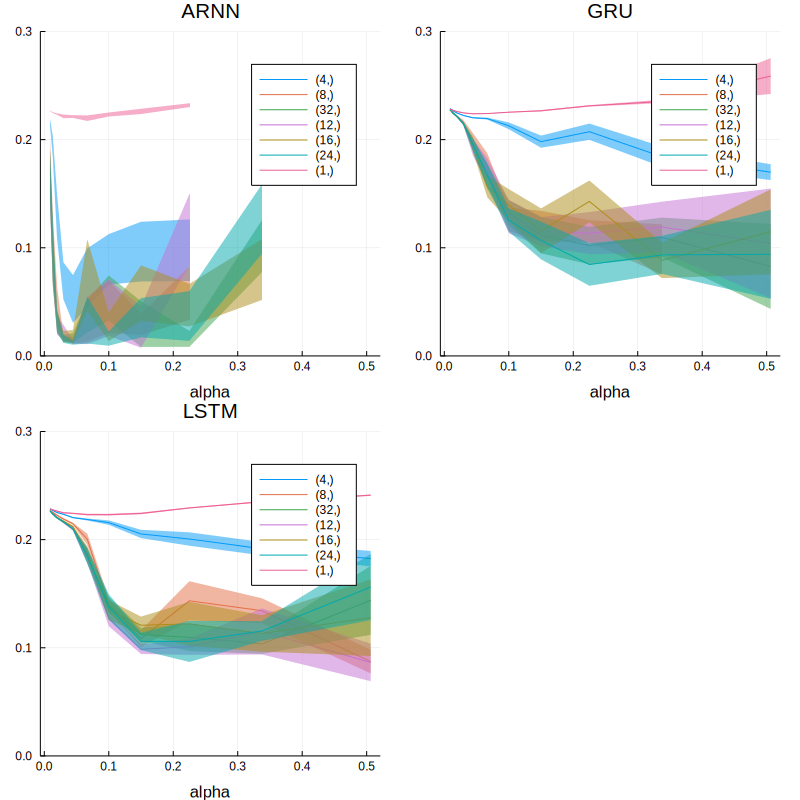

In [73]:
plot_rnn_stepsize_sens(ic_rnn, 35, "end"; ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.20230982969346462, 0.16844872064234448, 0.10262175771101723, 0.056689922206326626, 0.06433182237153148, 0.06286994453963356, 0.03456851186685184, 0.04031196700861245, 0.08754568523446887, 10000.0, 10000.0][0.01086482323097223, 0.019793932283649198, 0.020900589687114536, 0.01620932678950087, 0.0253410749776523, 0.024817229689094285, 0.01580069677669415, 0.013733581042078238, 0.03049052175910908, 0.0, 0.0]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.23114223251685537, 0.23069385425016065, 0.2305341269800368, 0.22985630083393632, 0.22858311172951992, 0.2269225234643399, 0.22402933364273378, 0.22221234265168274, 0.22025968861205114, 0.21797625217935215, 0.21563361837161663, 0.2098136032031393, 0.19535859513634019, 0.19077440409530197, 10000.0][0.00031117697782885427, 0.0004200401214017218, 0.0004927731069174707, 0.0005661263427875963, 0.0005376723669093071, 0.0005383304064780307, 0.0005670977172901189, 0.00045596751342604256, 0.00035487490320619357, 0.0005753269275216371, 0.001184688468506254, 0.00334115429903068, 0.007236757665000244, 0.012013642628042456, 0.0]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.231109266807819, 0.23014107517406562, 0.22954978705010878, 0.22851620550981883, 0.22698581585984723, 0.2256217669670276, 0.22437235970501015, 0.22151666712637988, 0.21919988829890075, 0.2175545409982814, 0.21676215793528392, 0.2095659264718178, 0.19987362863975783, 0.1797535351303869, 0.2093729310089168][0.0004381346231293315, 0.0005007292090909505, 0.0005893448959587436, 0.0007248717499722135, 0.0007300581710901828, 0.0007742013665989221, 0.000691219797191856, 0.0009212636508817724, 0.001013665913245372, 0.0008691232177978454, 0.0014095610656317003, 0.003586853239180056, 0.006421933951903049, 0.004171704330602233, 0.022525867720212943]


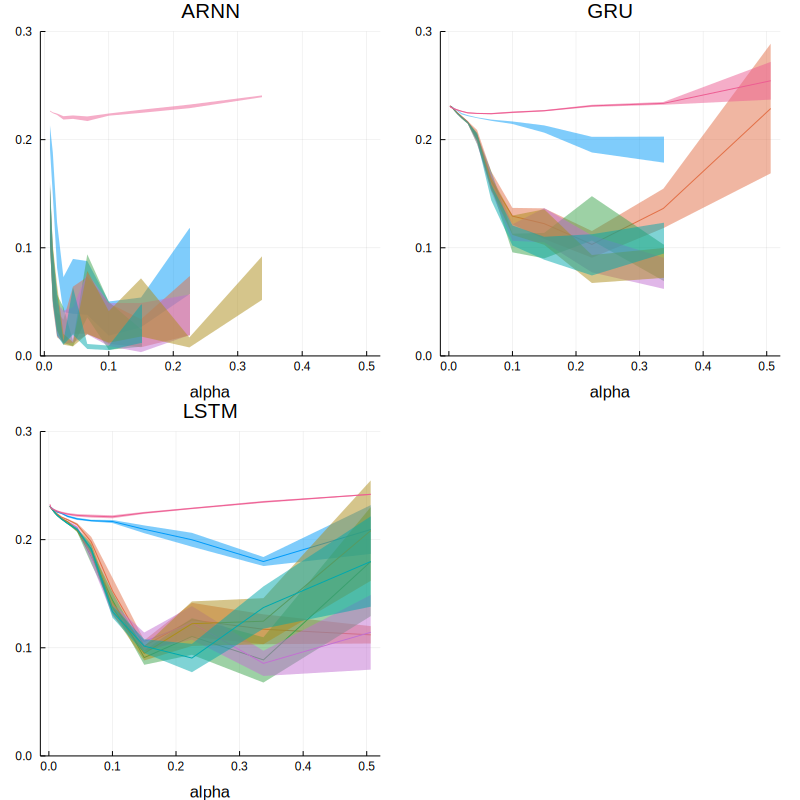

In [6]:
plot_rnn_stepsize_sens(ic_rnn, 40, "end"; ylims=(0.0,0.3), legend=false)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.09199113835514555, 0.025725482804325, 0.0282196638263139, 0.018160532382145197, 0.019085963928562728, 0.012405065949501247, 0.025432599338722495, 0.03247733787893993, 10000.0, 10000.0, 10000.0][0.015400164756034453, 0.0023038985591655216, 0.010154096233925878, 0.003543040770615485, 0.006394157546060041, 0.001175022013946815, 0.013760652051283713, 0.02269415741184239, 0.0, 0.0, 0.0]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.23126710171496692, 0.23098018339656762, 0.23024148134131622, 0.22926940216271627, 0.2274419757394913, 0.22597286247178566, 0.2243800830773342, 0.22279351091321584, 0.22160337657978832, 0.22108307349548162, 0.22082688250704555, 0.22221685532996327, 0.2263826667088574, 0.2241696878305252, 10000.0][0.0004002441850950426, 0.00038325054117723634, 0.0003724821172815269, 0.00034928462832918095, 0.00034377525537477357, 0.0003976122878966552, 0.00044352058678760314, 0.00039301596750737335, 0.000502432903900604, 0.0004856743462014682, 0.0009581525177133899, 0.0026324894162189734, 0.003621213804094779, 0.00797219593356576, 0.0]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.23153538982543592, 0.23076651620274893, 0.22967235468395444, 0.2280894088863358, 0.22537821608139597, 0.222704221772351, 0.22018830829250513, 0.21809888079854095, 0.21653463154696398, 0.2162632974878957, 0.2191644910318103, 0.21933691025083815, 0.2113490157000951, 0.2594651625260731, 0.3493792706238775][0.0004372889612658983, 0.0004897313145751364, 0.0005450584260573076, 0.0006159100423651584, 0.0007015155208509436, 0.0008138012845710569, 0.000764396793928939, 0.0007438509545389326, 0.0007429268509273324, 0.0007070925396292078, 0.0010719000931345318, 0.001959665550475765, 0.006346572807477589, 0.024827237147503324, 0.03018263887645126]


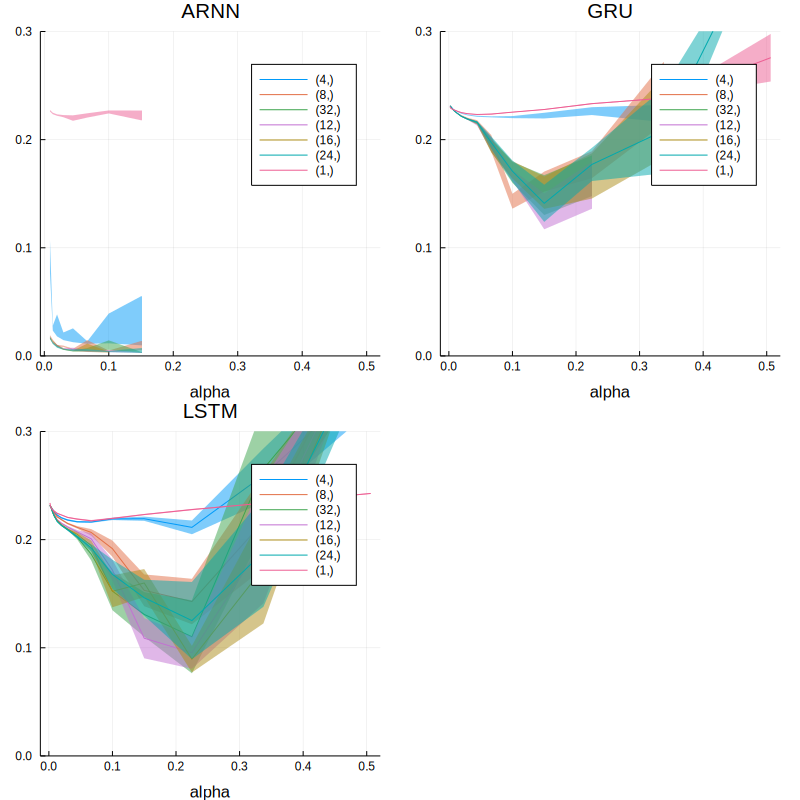

In [51]:
plot_rnn_stepsize_sens(ic_rnn, 110, "end"; ylims=(0.0,0.3))

In [125]:
ic_rnn_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_adam/data"));

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.22671166694593223, 0.21726076183478468, 0.11367749269045387, 0.016321304608068327, 0.011579539988114573, 0.02612941137069245, 0.17040143384907894, 0.24312901828769257, 0.27135372243787204, 0.41139258212855695][0.0004009509559820246, 0.0023101879578444067, 0.019631756956467055, 0.0013943022570307164, 0.0010090209145870558, 0.005005222802096768, 0.02451994702938342, 0.00023800140205223127, 0.0045853395283447975, 5.922871218244207e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.22574367678329293, 0.22268370703528823, 0.2097757149846534, 0.15431157571235207, 0.08053699843404447, 0.03929285053492158, 0.04278529748164889, 0.22104754749730823, 0.4020343492100521, 0.4114002007928672][0.0002068282656183006, 0.0003656418203107408, 0.0015132854472366187, 0.001779119173003013, 0.0072700912150016435, 0.004778233218666416, 0.003398259059416496, 0.006802755800641459, 4.179167256319839e-5, 5.897755060726786e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.22654248374296165, 0.2212218265675326, 0.21130065894413144, 0.1728162963931775, 0.10757928962105585, 0.05448232292772044, 0.08206924278892173, 0.1336370713366758, 0.2411136672347224, 0.3316680273580783][0.00045417714325164866, 0.000668891801492691, 0.0008984150213774606, 0.004616510973311303, 0.003574407186110399, 0.005187552197925503, 0.008104055313751432, 0.014694654853073868, 0.00022961619107179256, 0.022728366475908975]


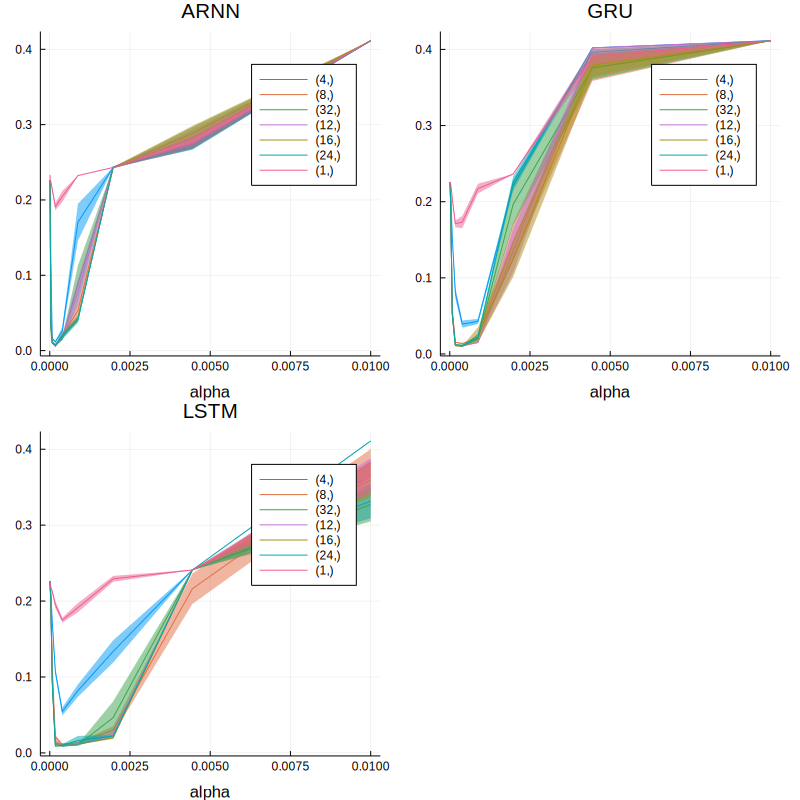

In [54]:
plot_rnn_stepsize_sens(ic_rnn_adam, 35, "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.2257430225892934, 0.21416292293722536, 0.06294854407377762, 0.0149273156115499, 0.012733827883796966, 0.023409920137668523, 0.20885041151515216, 0.24370552214358215, 0.3044421784777721, 0.41129319023404676][0.00034481932492404395, 0.002886272218073218, 0.01576067105957472, 0.001074354595387535, 0.0013895263805876498, 0.003909190227626544, 0.012244694948425226, 0.00029941949885169946, 0.01766151483281502, 7.073210203727883e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.22569074864671265, 0.2219091361454935, 0.20894516230048993, 0.14716832558377946, 0.07307440330556972, 0.03108366520982489, 0.06702144766304667, 0.2175030818135653, 0.40195961364249805, 0.41126392566759834][0.00043601548425272835, 0.000632221573083452, 0.0011328818681697733, 0.0025114818056556224, 0.0044622882619874986, 0.002317717484366402, 0.010118062764843318, 0.00805512153940564, 5.27578598815997e-5, 7.996786035791471e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.22560980103676548, 0.21936050146452696, 0.20803685484138085, 0.16832224351819197, 0.09607927674156627, 0.04629826874964581, 0.0664627307290385, 0.14848708407438715, 0.24105154442512328, 0.3877991366151713][0.0005037518152298972, 0.0007494658400617544, 0.0015446200002929382, 0.0031473936712905024, 0.007734073923370767, 0.004183472469050334, 0.0083804713027344, 0.016795119306054998, 0.0002562440814971347, 0.015057500638860577]


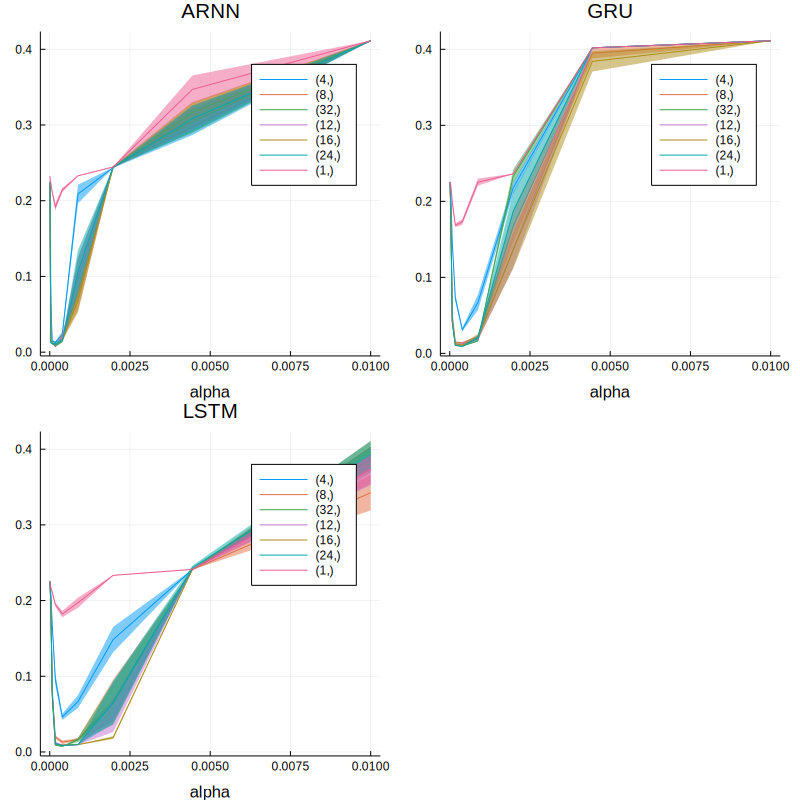

In [55]:
plot_rnn_stepsize_sens(ic_rnn_adam, 40, "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


[0.21508807511990052, 0.04741236584689532, 0.01508481020363355, 0.010555359850165527, 0.014921984339394716, 0.026830672285048464, 0.22140156373925596, 0.38144945814290787, 0.40206854914048257, 0.41140739226172574][0.0018198632733191181, 0.010326975162175617, 0.0006887539941034279, 0.0007627431474382991, 0.0013285176944579315, 0.0021976598030471225, 0.017442833555308304, 0.014180529423598027, 6.412908885697997e-5, 8.244789232411341e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.2225902900036107, 0.21266160293581118, 0.15696524348867308, 0.06363169184475098, 0.017372898227439003, 0.023032533910753095, 0.21990616581960745, 0.24262061546966013, 0.4019123743661953, 0.41121819054659536][0.0002780162091604761, 0.0005769476586367598, 0.0007856838710144626, 0.0070025742569443895, 0.0016723664907898996, 0.004087646333612491, 0.00655904536864363, 0.004142169505081045, 7.789868668566927e-5, 8.993718937422389e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


[0.220726796330255, 0.20931770180449752, 0.16328357642948235, 0.08967003800433748, 0.02963607797374048, 0.03276753819705891, 0.06745684040836612, 0.19846067829934383, 0.33762497024345156, 0.4113440345454281][0.0007923914751226489, 0.0009711901118123188, 0.002211733395693401, 0.009346130100007247, 0.0054794316319900695, 0.009474551858912264, 0.03691463841451989, 0.03762811253504647, 0.02630230287980564, 9.063651035569727e-5]


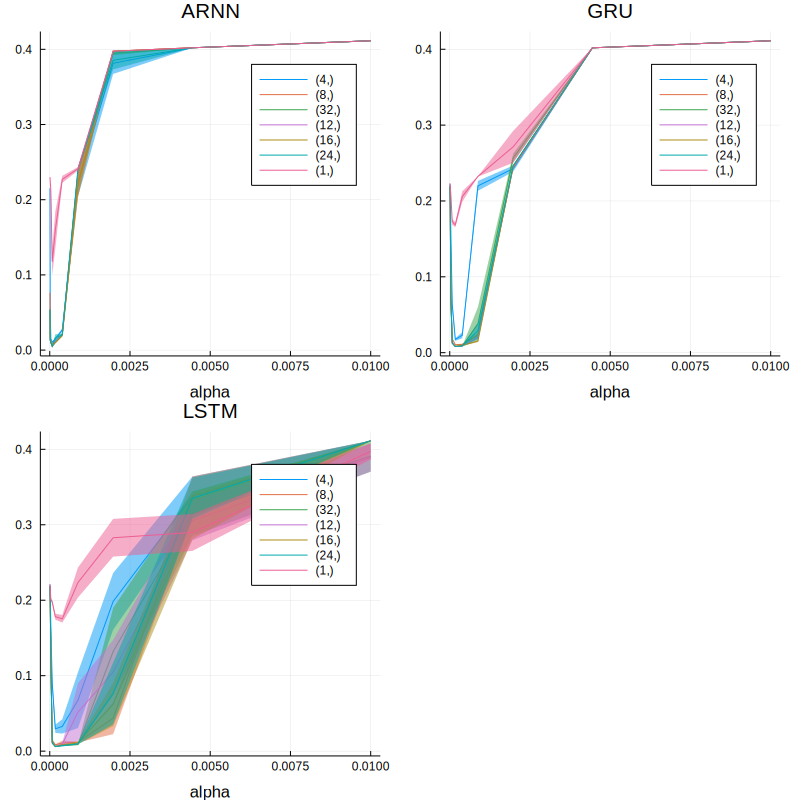

In [56]:
plot_rnn_stepsize_sens(ic_rnn_adam, 110, "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.24063410323331205, 0.22822779936062676, 0.22538862233705417, 0.22015107213492371, 0.1875442507025319, 0.13428075140789947, 0.21149812987634772, 0.2343417104202413, 0.24524890573748484, 0.39941641870369754][0.001251610137980333, 0.0004904157250221375, 0.0005571477085824859, 0.00442532896719855, 0.010560539633582625, 0.01761253714840487, 0.0027394117651616365, 0.00012453800421618593, 0.00025203807363441037, 0.006630904257452644]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.2276416148076105, 0.226567996928306, 0.22527193455624572, 0.21395347722811797, 0.1653454947516097, 0.13879186421554507, 0.11648823304312639, 0.2121846273945021, 0.2447195590419514, 0.41142296195097333][0.00024550657850236693, 0.000210577888193568, 0.0007330778894532895, 0.002300592597482656, 0.003957077183302882, 0.005495019882696864, 0.010462035072034217, 0.011494699623177701, 0.00026518944151659595, 8.234926585157512e-5]


Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


[0.23173872355705324, 0.22827608154088494, 0.22742099242156028, 0.2247075902117465, 0.1966317516856886, 0.1505073681921452, 0.15030284118974901, 0.22481508551184196, 0.2408635086885565, 0.3850205115384817][0.0007410597080992196, 0.0002968088592657315, 0.00046017945501549746, 0.0012101965361158583, 0.004929735553437233, 0.005045074845281504, 0.011986255996643009, 0.008063262533132685, 0.00020391234682142406, 0.01754317370269814]


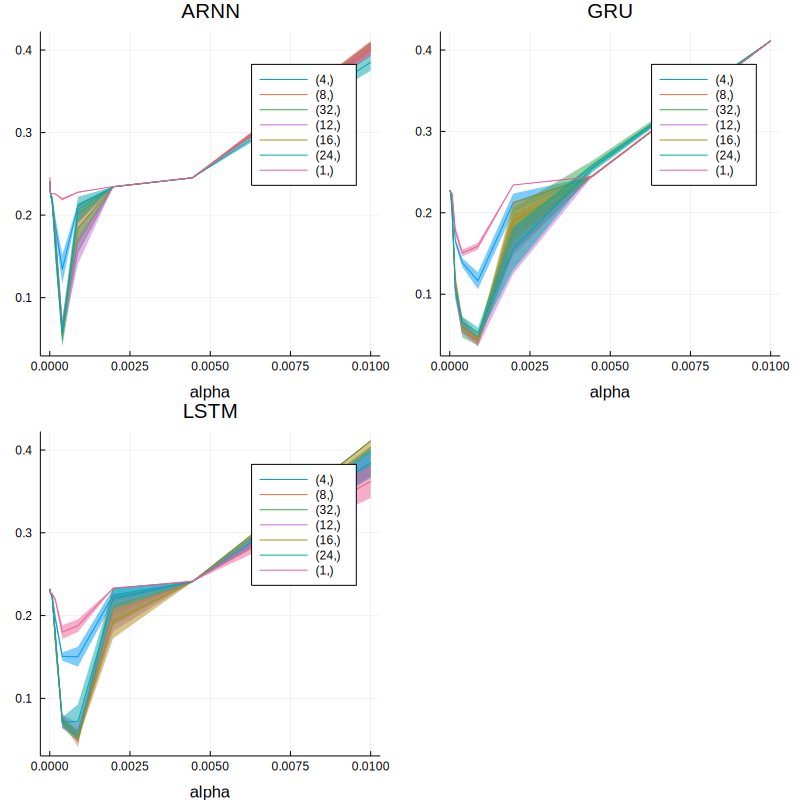

In [126]:
plot_rnn_stepsize_sens(ic_rnn_adam, 5, "end")

## RNN Aux Tasks

In [6]:
ic_rnn_at = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task/data"));
diff(ic_rnn_at)

Dict{String,Array} with 5 entries:
  "at-horde"   => ["gammas_aj_term", "rafols"]
  "alpha"      => [0.00173415, 0.00260123, 0.00390184, 0.00585277, 0.00877915, …
  "truncation" => [1, 4, 8, 12, 16, 24, 32]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "cell"       => ["ARNN", "GRU", "LSTM"]

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


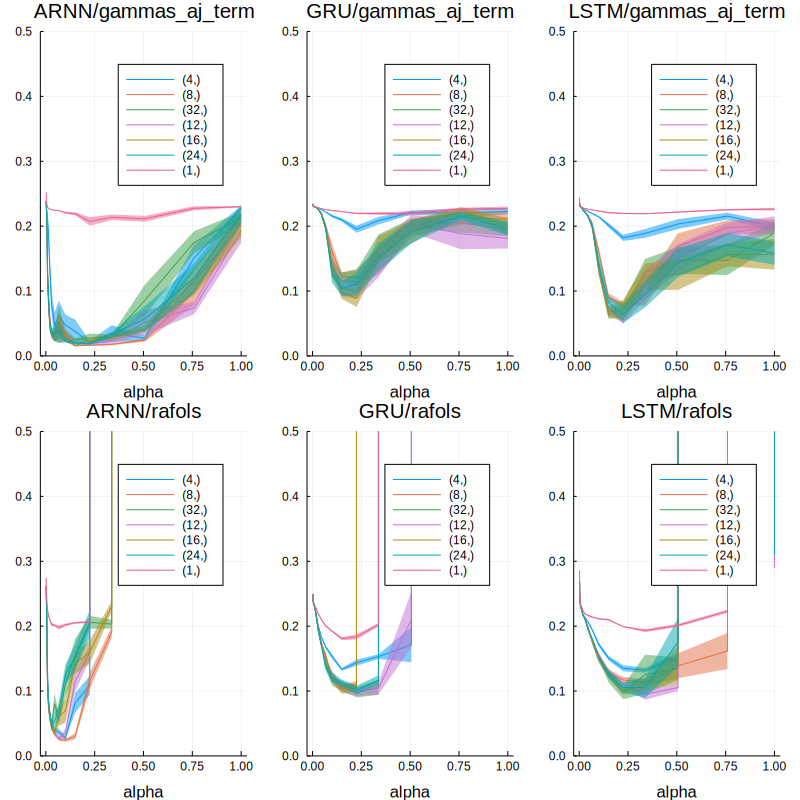

In [12]:
plot_rnn_at_stepsize_sens(ic_rnn_at, "end"; ylims=(0.0, 0.5))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


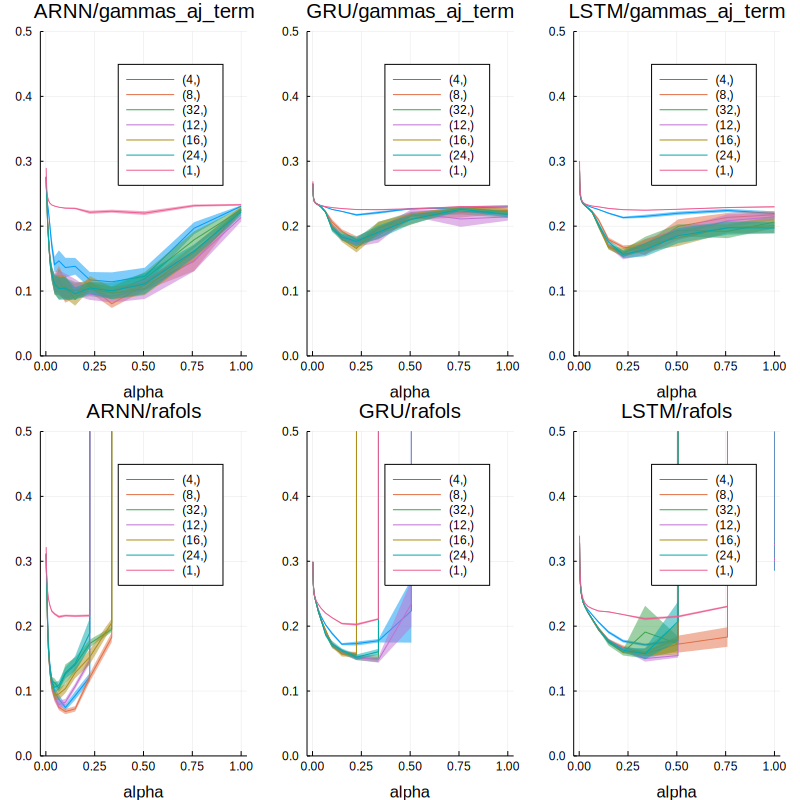

In [13]:
plot_rnn_at_stepsize_sens(ic_rnn_at, "all"; ylims=(0.0, 0.5))

In [15]:
ic_rnn_at_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task_adam/data"));
diff(ic_rnn_at_adam)

Dict{String,Array} with 5 entries:
  "at-horde"   => ["gammas_aj_term", "rafols"]
  "alpha"      => [6.76639e-6, 1.52244e-5, 3.42549e-5, 7.70735e-5, 0.000173415,…
  "truncation" => [1, 4, 8, 12, 16, 24, 32]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "cell"       => ["ARNN", "GRU", "LSTM"]

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


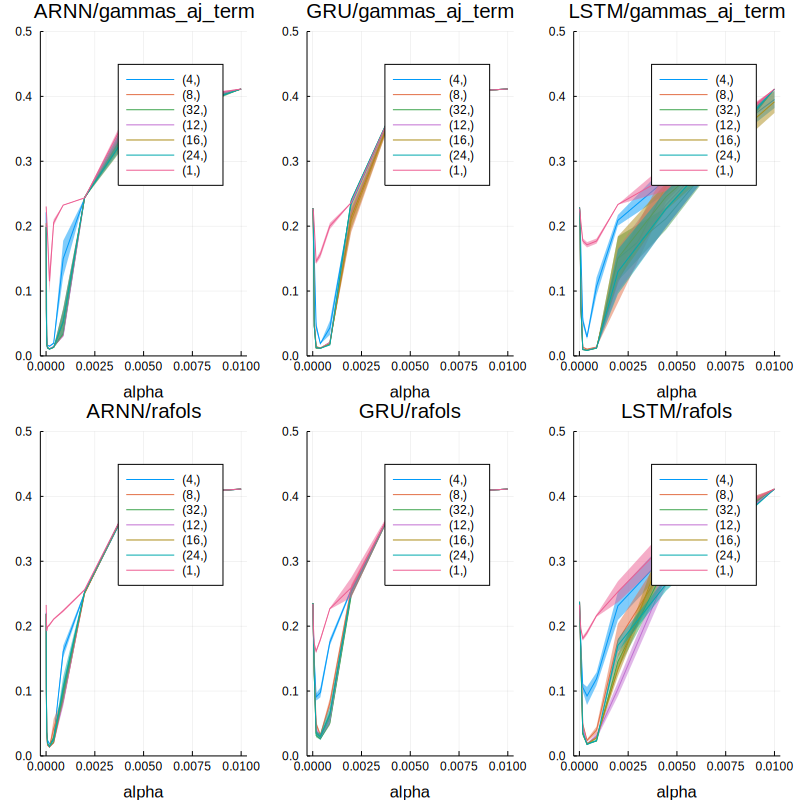

In [16]:
plot_rnn_at_stepsize_sens(ic_rnn_at_adam, "end"; ylims=(0.0, 0.5))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


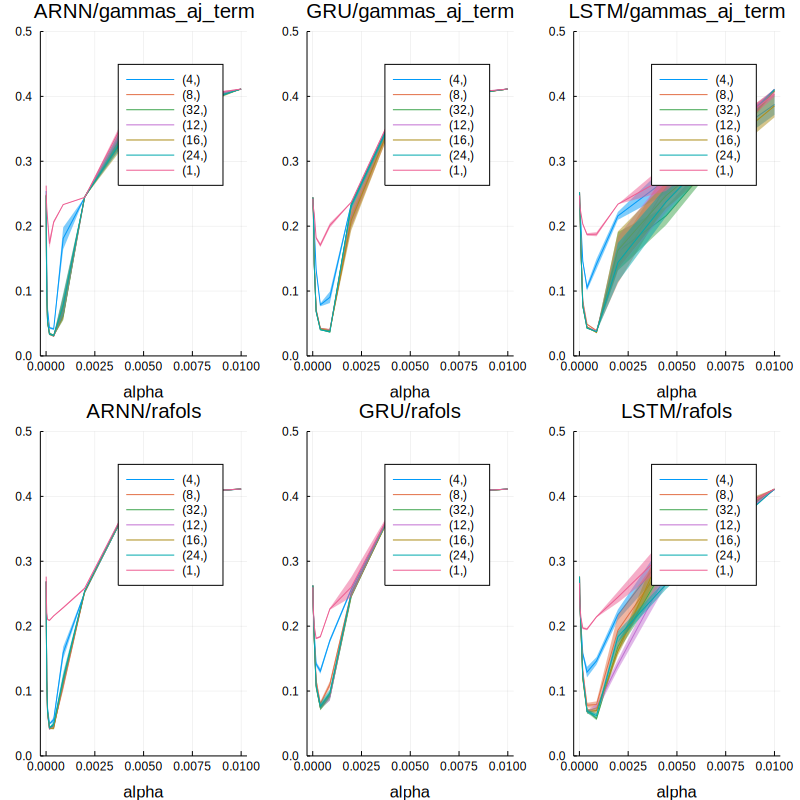

In [17]:
plot_rnn_at_stepsize_sens(ic_rnn_at_adam, "all"; ylims=(0.0, 0.5))

# Final Params

In [18]:
function get_final_gvfn_params(ic, res_key)

    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    sub_ic = ic
    arg_list = Dict{String, Any}[]
    @showprogress for horde ∈ diff(sub_ic)["gvfn-horde"]
        sub_sub_ic = search(sub_ic, Dict("gvfn-horde"=>horde))
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, _ = get_best_func(sub_sub_sub_ic)
            push!(arg_list, Dict("gvfn-horde"=>horde, "truncation"=>τ, "alpha"=>prm))
        end

    end
    arg_list
end

function get_final_rnn_params(ic, res_key)

    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    sub_ic = ic
    arg_list = Dict{String, Any}[]
    for cell ∈ diff(sub_ic)["cell"]
        sub_sub_ic = search(sub_ic, Dict("cell"=>cell))
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, (μ, σ) = get_best_func(sub_sub_sub_ic)
#             println(μ)
            push!(arg_list, Dict("cell"=>cell, "truncation"=>τ, "alpha"=>prm)) #itm.parsed_args
        end
    end
    arg_list
end

function get_final_rnn_at_params(ic, res_key)

    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    sub_ic = ic
    arg_list = Dict{String, Any}[]
    for (horde, cell) ∈ Iterators.product(diff(sub_ic)["at-horde"], diff(sub_ic)["cell"])
        sub_sub_ic = search(sub_ic, Dict("cell"=>cell, "at-horde"=>horde))
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, (μ, σ) = get_best_func(sub_sub_sub_ic)
#             println(μ)
            push!(arg_list, Dict("cell"=>cell, "at-horde"=>horde, "truncation"=>τ, "alpha"=>prm)) #itm.parsed_args
        end
    end
    arg_list
end


get_final_rnn_at_params (generic function with 1 method)

## GVFN

In [3]:
ic_gvfn = ItemCollection(joinpath(data_home, "compassworld_gvfn/data"));
ic_gvfn_rmsprop = ItemCollection(joinpath(data_home, "compassworld_gvfn_rmsprop/data"));
ic_gvfn_adam = ItemCollection(joinpath(data_home, "compassworld_gvfn_adam/data"));

In [64]:
diff(ic_gvfn)
ic_gvfn.items[1].parsed_args

Dict{String,Any} with 15 entries:
  "opt"        => "Descent"
  "steps"      => 1000000
  "_GIT_INFO"  => "0"
  "activation" => "sigmoid"
  "sweep"      => true
  "policy"     => "rafols"
  "alpha"      => 0.15
  "size"       => 8
  "out-horde"  => "forward"
  "save_dir"   => "/home/mkschleg/scratch/GVFN/compassworld_gvfn/data"
  "_HASH"      => 0x1011e0bd89b3a604
  "gvfn-horde" => "gammas_aj_term"
  "truncation" => 32
  "seed"       => 4
  "_SAVE"      => "/home/mkschleg/scratch/GVFN/compassworld_gvfn/data/RP_0_0x10…

In [116]:
args_list = get_final_gvfn_params(ic_gvfn, "end")
@save "../final_run_params/compassworld/compassworld_gvfn_descent.jld2" args_list

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [21]:
args_list = get_final_gvfn_params(ic_gvfn_rmsprop, "end")
@save "../final_run_params/compassworld/compassworld_gvfn_rmsprop.jld2" args_list

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [22]:
args_list = get_final_gvfn_params(ic_gvfn_adam, "end")
@save "../final_run_params/compassworld/compassworld_gvfn_adam.jld2" args_list

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [117]:
args_list = get_final_gvfn_params(ic_gvfn, "all")
@save "../final_run_params/compassworld/compassworld_gvfn_descent_all.jld2" args_list

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [118]:
args_list = get_final_gvfn_params(ic_gvfn_rmsprop, "all")
@save "../final_run_params/compassworld/compassworld_gvfn_rmsprop_all.jld2" args_list

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [119]:
args_list = get_final_gvfn_params(ic_gvfn_adam, "all")
@save "../final_run_params/compassworld/compassworld_gvfn_adam_all.jld2" args_list

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


## RNN

In [131]:
ic_rnn = ItemCollection(joinpath(data_home, "compassworld_rnn/data"));
ic_rnn_rmsprop = ItemCollection(joinpath(data_home, "compassworld_rnn_rmsprop/data"));
ic_rnn_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_adam/data"));

In [24]:
diff(ic_rnn)

Dict{String,Array} with 5 entries:
  "hidden"     => [35, 40, 110]
  "alpha"      => [0.00173415, 0.00260123, 0.00390184, 0.00585277, 0.00877915, …
  "truncation" => [1, 4, 8, 12, 16, 24, 32]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "cell"       => ["ARNN", "GRU", "LSTM"]

In [76]:
ic_rnn_40 = search(ic_rnn, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_40, "end")
@save "../final_run_params/compassworld/compassworld_rnn_40.jld2" args_list


In [77]:
ic_rnn_adam_40 = search(ic_rnn_adam, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_adam_40, "end")
@save "../final_run_params/compassworld/compassworld_rnn_adam_40.jld2" args_list


In [132]:
ic_rnn_5 = search(ic_rnn, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_5, "end")
@save "../final_run_params/compassworld/compassworld_rnn_5.jld2" args_list


In [129]:
ic_rnn_adam_5 = search(ic_rnn_adam, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_adam_5, "end")
@save "../final_run_params/compassworld/compassworld_rnn_adam_5.jld2" args_list


In [120]:
ic_rnn_40 = search(ic_rnn, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_40, "all")
@save "../final_run_params/compassworld/compassworld_rnn_40_all.jld2" args_list


In [121]:
ic_rnn_adam_40 = search(ic_rnn_adam, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_adam_40, "all")
@save "../final_run_params/compassworld/compassworld_rnn_adam_40_all.jld2" args_list


In [133]:
ic_rnn_5 = search(ic_rnn, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_5, "all")
@save "../final_run_params/compassworld/compassworld_rnn_5_all.jld2" args_list


In [134]:
ic_rnn_adam_5 = search(ic_rnn_adam, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_adam_5, "all")
@save "../final_run_params/compassworld/compassworld_rnn_adam_5_all.jld2" args_list


### AT RNNs

In [20]:
ic_rnn_at = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task/data"));
# ic_rnn_rmsprop = ItemCollection(joinpath(data_home, "compassworld_rnn_rmsprop/data"));
ic_rnn_at_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task_adam/data"));

In [21]:
args_list = get_final_rnn_at_params(ic_rnn_at, "end")
@save "../final_run_params/compassworld/compassworld_rnn_aux_task.jld2" args_list

In [22]:
args_list = get_final_rnn_at_params(ic_rnn_at_adam, "end")
@save "../final_run_params/compassworld/compassworld_rnn_aux_task_adam.jld2" args_list

# Forecast Networks

In [106]:
ic_forecast = ItemCollection(joinpath(data_home, "compassworld_forecast/data"));
ic_forecast_rmsprop = ItemCollection(joinpath(data_home, "compassworld_forecast_rmsprop/data"));
ic_forecast_adam = ItemCollection(joinpath(data_home, "compassworld_forecast_adam/data"));

In [82]:
diff(ic_forecast_adam)

Dict{String,Array} with 5 entries:
  "alpha"      => [0.000173415, 0.000390184, 0.000877915, 0.00197531, 0.0044444…
  "truncation" => [1, 4, 8, 12, 16, 24, 32]
  "klength"    => [8, 22]
  "seed"       => [1, 2, 3, 4, 5]
  "cell"       => ["ARNNCell", "GRUCell", "LSTMCell"]

In [109]:
ic_forecast_8 = search(ic_forecast, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_8, "end")
@save "../final_run_params/compassworld/compassworld_forecast_8.jld2" args_list

In [110]:
ic_forecast_rmsprop_8 = search(ic_forecast_rmsprop, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_rmsprop_8, "end")
@save "../final_run_params/compassworld/compassworld_forecast_rmsprop_8.jld2" args_list

In [111]:
ic_forecast_adam_8 = search(ic_forecast_adam, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_adam_8, "end")
@save "../final_run_params/compassworld/compassworld_forecast_adam_8.jld2" args_list

In [122]:
ic_forecast_8 = search(ic_forecast, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_8, "all")
@save "../final_run_params/compassworld/compassworld_forecast_8_all.jld2" args_list

In [123]:
ic_forecast_rmsprop_8 = search(ic_forecast_rmsprop, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_rmsprop_8, "all")
@save "../final_run_params/compassworld/compassworld_forecast_rmsprop_8_all.jld2" args_list

In [124]:
ic_forecast_adam_8 = search(ic_forecast_adam, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_adam_8, "all")
@save "../final_run_params/compassworld/compassworld_forecast_adam_8_all.jld2" args_list